In this project, we will use python to automate the task of downloading a large (36) number of NAIP imagery tiles. We will then read in the datasets sequentially, extract the bounding geometry, and create a shapefile of polygons representing the tile boundaries.

First, let's import the modules needed for this project.

In [64]:
import geopandas as gpd
import pandas as pd
import rasterio
import os
import requests
from shapely.geometry import Polygon

The the "data.csv" file in the data folder contains a list of imagery file urls that intersect our area of interest. We will first read the data into a pandas dataframe. The data file doesn't have a header so the columns are assigned numerical values.

In [ ]:
tile_data = pd.read_csv('./data/data.csv', header=None)
tile_data

Next, we will create a new empty dataframe and copy to it column number 14, which contains the download urls for the imagery files.

In [ ]:
downloads = pd.DataFrame()
downloads['url'] = tile_data[14]
downloads

We will then extract the file names from the url path and store it in the "file_name" column.

In [ ]:
def get_file_name(url):
    return os.path.split(url)[1]

downloads['file_name'] = downloads['url'].apply(get_file_name)
downloads

We will then create a new column "download_success" which records whether the download was successful or not. We will assign initial values to false.

In [ ]:
downloads['download_success'] = False
downloads

The next step is to iterate through the rows of the downloads dataframe. In general, there are better ways to iterate through the rows rather than iterrows(). However, it is OK in this case because there are not a lot of records (36), and so there won't be a significant performance penalty.

For each row, we will extract the url of the tile and attempt to download it using the requests.get() method. If the status code of the response is 200, then the file has been successfully downloaded.  In that case, we will save the file to the "tiles/img" folder and update the downloads dataframe to indicate that the download was successful for that tile.

In [29]:
num_rows = len(downloads.index)
for index, tile in downloads.iterrows():
    url = tile['url']
    response = requests.get(url)
    if response.status_code == 200:
        file_name = tile['file_name']
        out_file_path = f'./tiles/img/{file_name}'
        with open(out_file_path, 'wb') as handler:
            img_data = response.content
            handler.write(img_data)
        downloads.at[index,'download_success'] = True
    print(f'finished processing file num {index+1} of {num_rows}')



finished processing file num 1 of 36
finished processing file num 2 of 36
finished processing file num 3 of 36
finished processing file num 4 of 36
finished processing file num 5 of 36
finished processing file num 6 of 36
finished processing file num 7 of 36
finished processing file num 8 of 36
finished processing file num 9 of 36
finished processing file num 10 of 36
finished processing file num 11 of 36
finished processing file num 12 of 36
finished processing file num 13 of 36
finished processing file num 14 of 36
finished processing file num 15 of 36
finished processing file num 16 of 36
finished processing file num 17 of 36
finished processing file num 18 of 36
finished processing file num 19 of 36
finished processing file num 20 of 36
finished processing file num 21 of 36
finished processing file num 22 of 36
finished processing file num 23 of 36
finished processing file num 24 of 36
finished processing file num 25 of 36
finished processing file num 26 of 36
finished processing f

After the files have all been downloaded, we will extract the bounding geometry. For each row in the downloads dataframe, if the download was successful, then we will open the file using the rasterio.open() method. We will then extract the bounding geometry and convert it to a polygon. The result is stored in a data series.

In [70]:
def convert_bounds(bounds):
    top_left = [bounds.left, bounds.top]
    top_right = [bounds.right, bounds.top]
    bottom_right = [bounds.right, bounds.bottom]
    bottom_left = [bounds.left, bounds.bottom]
    return Polygon([top_left, top_right, bottom_right, bottom_left])

def process_tile(tile):
    if tile['download_success'] == True:
        file_name = tile['file_name']
        dataset = rasterio.open(f'./tiles/img/{file_name}')
        geom = convert_bounds(dataset.bounds)
        return geom

geom = downloads.apply(process_tile, axis=1)
geom

0     POLYGON ((-7618430.581099734 5543150.977266097...
1     POLYGON ((-7625388.852902955 5543150.451160067...
2     POLYGON ((-7618430.624364643 5533400.132870712...
3     POLYGON ((-7625388.486028725 5533400.608641249...
4     POLYGON ((-7604515.433672311 5543150.477757988...
5     POLYGON ((-7611473.308643891 5543150.783950681...
6     POLYGON ((-7604515.899064953 5533400.024699969...
7     POLYGON ((-7611473.762201365 5533400.938273258...
8     POLYGON ((-7590600.293431066 5543150.103671419...
9     POLYGON ((-7597558.158418234 5543150.846230178...
10    POLYGON ((-7590600.578854679 5533400.650295801...
11    POLYGON ((-7597558.034481674 5533400.988433592...
12    POLYGON ((-7583643.014475231 5543150.628223271...
13    POLYGON ((-7583643.725840408 5533400.176336662...
14    POLYGON ((-7618430.991762367 5523661.019965525...
15    POLYGON ((-7625388.452404506 5523661.49644241,...
16    POLYGON ((-7618430.890580118 5513933.180829233...
17    POLYGON ((-7625388.967684463 5513933.65897

We need to get the coorinate reference system of the tiles. We will assume that the CRS is the same for all the downloads. To get it, will extract all the tile records for which the download was successful. We'll select the first one, open it, and store the CRS info.

In [81]:
downloaded = downloads.loc[downloads['download_success']==True]
row = downloaded.loc[0]
file_name = row['file_name']
dataset = rasterio.open(f'./tiles/img/{file_name}')
crs = dataset.crs

EPSG:3857


Finally, we will create a new geodataframe using geopandas. We will assign the polygon boundaries data series as the geometry. We will also copy the file names into the dataframe. We will plot the tiles to see what they look like. In the plot, the polygon edges are not visible so it looks like the tiles have been merged, even though they have not been. This is OK. Finally, we will save the data to a shapefile.

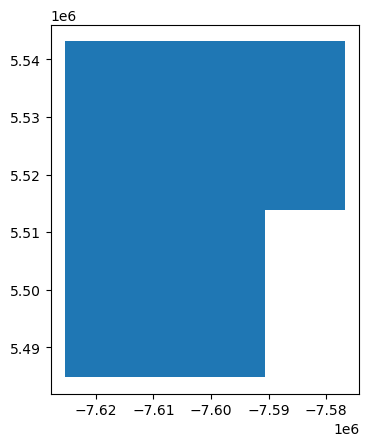

In [83]:
gdf = gpd.GeoDataFrame(columns=['file_name', 'geometry'], geometry='geometry', crs=crs)
gdf['geometry'] = geom
gdf['file_name'] = downloads['file_name']
gdf.plot()
gdf.to_file('./tiles/boundaries/boundaries.shp')